# Dependence of the soiling rate of solar concentrators on weather parameters.

The dataset used here is the data provided from "DailyData_PSA.mat"

In [60]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
import TSAPipe
import main
# Import supplementary visualization code visuals.py
import visuals as vs
# Pretty display for notebooks
%matplotlib inline
#avoid scientific notation
pd.options.display.float_format = '{:20,.4f}'.format

In [61]:
# Load the Full data set
data = pd.read_csv("E:\!Weiterbildung\DLR\soiling\code\datasets\\FullData_PSA.csv")

#rename old timeline
data.rename(columns = {'dateNum':'time'}, inplace = True)

In [62]:
#print data.columns.values

In [63]:
data.columns = ['time', 'cleanlinessraw', 'cleanliness', 'cleanlinesscorr', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07',
                'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 
                'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36',
               'f37', 'f38', 'f39', 'f40']
print np.shape(data)

(875521, 43)


### Plot the cleanliness of train/test- and validation data set

the cleanliness data is only available from sunrise to sunset. There are outliers and the data is skewed.

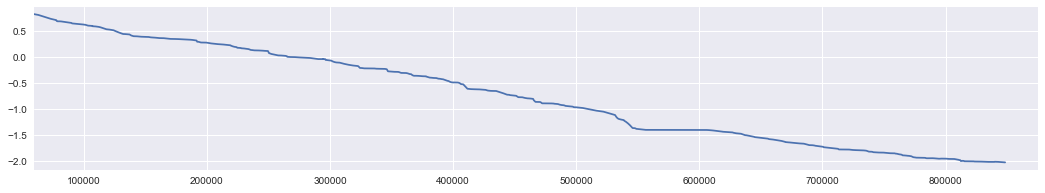

In [64]:
fig = plt.figure(figsize=(18,3))
data['cleanlinesscorr'].iloc[59450:].plot()
plt.show()

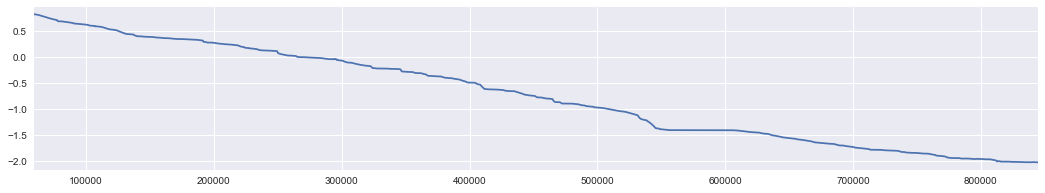

In [65]:
fig = plt.figure(figsize=(18,3))
data['cleanlinesscorr'].iloc[59450:845000].plot()
plt.show()

data1 = data.iloc[59450:845000]

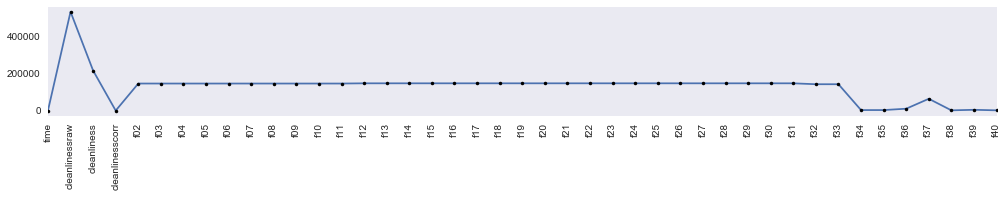

In [66]:
TSAPipe.visualizeNaN(data1)

### Zeitraum ausgeben

In [67]:
import time
#from datetime import date
from datetime import timedelta
from datetime import datetime

for e in data1.time.iloc[[0, -1]]:
    print datetime.fromordinal(int(e))+ timedelta(days=e%1) - timedelta(days = 366)

2013-06-11 06:49:59.999982
2014-12-08 19:18:59.999989


### remove NaNs and reset Index

In [68]:
data1 = main.removeNaN(data1, ['cleanlinesscorr'])
data1 = main.rebuild_index(data1)

number of data points BEFORE dropping all rows with any NaN elements for selected features: 785550
number of data points AFTER dropping all rows with any NaN elements for selected features: 785549
1 number of data points deleted



### extract days with real measurement data

In [69]:
wds = main.extractDays(data1, 400)
del wds['day495'] #NaN day

In [70]:
#for e in wds:
#    print wds[e]['end'] - wds[e]['start']

display(wds)

{'day00': {'end': 2815, 'start': 2295},
 'day01': {'end': 11563, 'start': 11448},
 'day02': {'end': 12999, 'start': 12191},
 'day03': {'end': 14443, 'start': 13634},
 'day04': {'end': 15854, 'start': 15094},
 'day05': {'end': 17306, 'start': 16545},
 'day06': {'end': 18665, 'start': 17961},
 'day07': {'end': 19543, 'start': 19434},
 'day08': {'end': 21642, 'start': 20977},
 'day09': {'end': 23082, 'start': 22274},
 'day10': {'end': 24522, 'start': 23714},
 'day100': {'end': 154021, 'start': 153390},
 'day101': {'end': 155202, 'start': 154840},
 'day102': {'end': 156847, 'start': 156383},
 'day103': {'end': 158337, 'start': 157705},
 'day104': {'end': 159767, 'start': 159146},
 'day105': {'end': 161214, 'start': 160594},
 'day106': {'end': 162652, 'start': 162028},
 'day107': {'end': 164091, 'start': 163469},
 'day108': {'end': 165479, 'start': 164931},
 'day109': {'end': 166968, 'start': 166351},
 'day11': {'end': 25962, 'start': 25155},
 'day110': {'end': 168360, 'start': 167792},
 'd

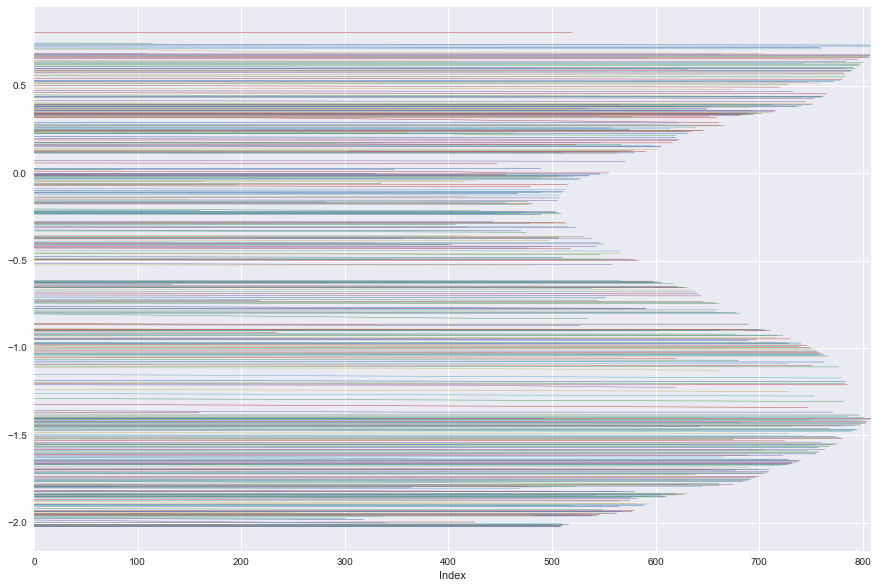

In [71]:
fig = plt.figure(figsize=(15,10))
for e in wds:
    tempdata = data1['cleanlinesscorr'][wds[e]['start'] : wds[e]['end']]
    tempdata = pd.DataFrame(tempdata)
    #tempdata = main.removeNaN(tempdata, ['cleanlinesscorr'])
    tempdata = main.rebuild_index(tempdata)
    tempdata['cleanlinesscorr'].plot(lw=0.5)
plt.show()

### Savin the original data set for "MDMS testing"

In [72]:
mdms_data = data1

### build new dataframe with only measured cleanliness data and calculated soiling rate

In [73]:
i=0
#create first day
day_data = data1[wds['day{:02d}'.format(i)]['start'] : wds['day{:02d}'.format(i)]['end']]
day_data.loc[:, 'sr_highres'] = day_data.loc[:, 'cleanlinesscorr'].diff()/day_data['time'].diff()
day_data = pd.DataFrame(day_data)

for i in range(1, 494, 1):
    #assign data of day window to tempdata
    tempdata = data1[wds['day{:02d}'.format(i)]['start'] : wds['day{:02d}'.format(i)]['end']]
    #calc. soiling rate
    tempdata.loc[:, 'sr_highres'] = tempdata.loc[:, 'cleanlinesscorr'].diff()/tempdata['time'].diff()
    #fill in mean for 1 missing value (NaN)
    tempdata.loc[:, 'sr_highres']= tempdata.loc[:, 'sr_highres'].fillna(tempdata['sr_highres'].mean())
    # rolling centered average using 5 values
    tempdata.loc[:, 'sr_highres'] = tempdata.loc[:, 'sr_highres'].rolling(10, center=True).mean()
    #fill in mean for missing value (NaN)
    tempdata.loc[:, 'sr_highres']= tempdata.loc[:, 'sr_highres'].fillna(tempdata['sr_highres'].mean())
    frame = [day_data, tempdata]
    day_data = pd.concat(frame)

In [74]:
day_data = main.rebuild_index(day_data)

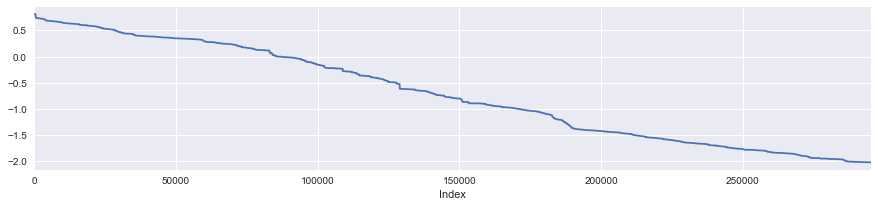

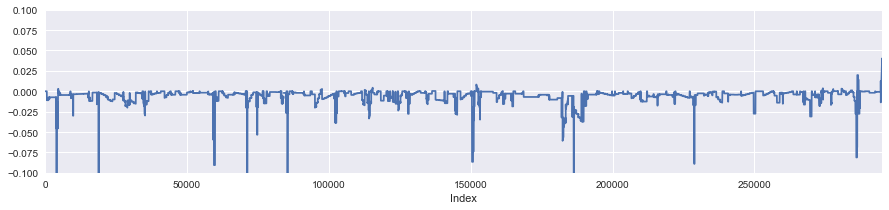

In [75]:
#display(data1.describe())
#display(day_data.describe())

#fig = plt.figure(figsize=(15,5))
#data1['cleanlinesscorr'].plot()

fig = plt.figure(figsize=(15,3))
day_data['cleanlinesscorr'].plot()

fig = plt.figure(figsize=(15,3))
day_data['sr_highres'].plot()
plt.ylim(-0.1, 0.1)
plt.show()

### Drop features that are not needed (domain knowledge)

The following features are deleted because their distribution is regarded as impossible to transform into a normal distribution. They are thus not useful for the regression algorithms. Most of the PartDiam features fall into this category.

In [76]:
#remove columns
featurelist =['f36', 'f32', 'f33', 'cleanlinesscorr', 'cleanlinessraw', 'cleanliness', 'f38']

for e in featurelist:
    day_data = day_data.drop(e, axis = 1)
    mdms_data = mdms_data.drop(e, axis = 1)
    
print day_data.columns.values

['time' 'f02' 'f03' 'f04' 'f05' 'f06' 'f07' 'f08' 'f09' 'f10' 'f11' 'f12'
 'f13' 'f14' 'f15' 'f16' 'f17' 'f18' 'f19' 'f20' 'f21' 'f22' 'f23' 'f24'
 'f25' 'f26' 'f27' 'f28' 'f29' 'f30' 'f31' 'f34' 'f35' 'f37' 'f39' 'f40'
 'sr_highres']


### Filling in mean values for missing values

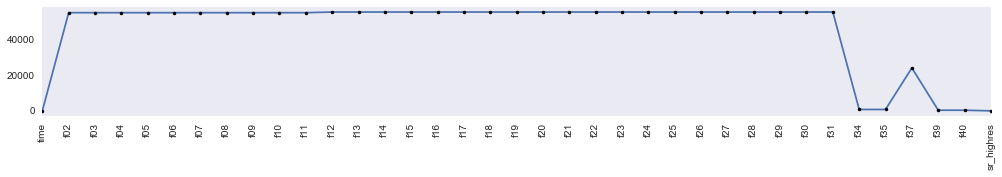

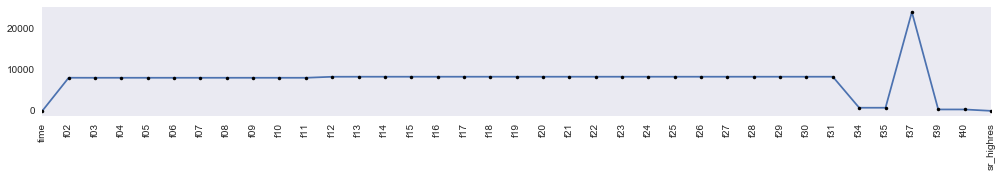

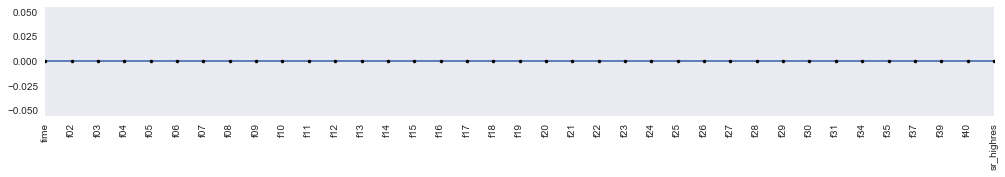

In [77]:
TSAPipe.visualizeNaN(day_data)
day_data = day_data.fillna(method='pad', limit=1)
TSAPipe.visualizeNaN(day_data)

day_data = day_data.fillna(day_data.mean())
#data1 = data1.fillna(value=0)
TSAPipe.visualizeNaN(day_data)

mdms_data = mdms_data.fillna(method='pad', limit=1)
mdms_data = mdms_data.fillna(mdms_data.mean())

### Outlier detection for selected features

outliers are replaced by NaN when using main.outlierDet() or are removed when using main.outlierRem()

In [78]:
#for e in day_data.columns.values:
for e in ['f39', 'f40']:
    day_data = main.outlierRem(day_data, e)
    mdms_data = main.outlierRem(mdms_data, e)

number of Data points considered outliers for the feature 'f39': 3870
number of Outliers that occur various times and thus are NOT removed '0':

number of Data points considered outliers for the feature 'f39': 1
number of Outliers that occur various times and thus are NOT removed '0':

number of Data points considered outliers for the feature 'f40': 10433
number of Outliers that occur various times and thus are NOT removed '0':

number of Data points considered outliers for the feature 'f40': 34988
number of Outliers that occur various times and thus are NOT removed '0':



,time,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f28,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres
count,"280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000",...,"280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000","280,833.0000"
mean,"735,662.6777","22,469.1404","13,189.0190","8,268.0871","4,621.6394","1,590.6132",570.2933,716.4162,337.8433,172.1172,...,0.2593,0.3002,0.1365,0.1187,4.5885,168.9749,0.1770,39.6892,958.4992,-0.0059
std,159.9837,"16,240.2956","10,973.1961","7,464.5637","4,611.8955","1,634.4229",557.8383,606.2924,310.7432,195.2658,...,2.2679,2.7356,1.3975,1.7219,2.4024,80.3239,0.5140,14.1252,3.9744,0.0113
min,"735,397.8785",-718.0000,-799.0000,-411.0000,-408.0000,-385.0000,-73.0000,-51.0000,"-17,456.0000",-107.0000,...,-0.5000,0.0000,-0.5000,-0.5000,0.0000,0.0000,0.0000,3.2000,947.4000,-0.8755
25%,"735,507.0965","9,820.0000","4,985.0000","2,965.0000","1,630.0000",610.0000,250.0000,355.0000,175.0000,85.0000,...,0.0000,0.0000,0.0000,0.0000,2.7000,100.6000,0.0000,28.9000,955.9000,-0.0070
50%,"735,672.1500","19,380.0000","10,420.0000","6,175.0000","3,285.0000","1,130.0000",430.0000,570.0000,285.0000,140.0000,...,0.0000,0.0000,0.0000,0.0000,4.5846,152.9000,0.0000,37.9000,958.3000,-0.0037
75%,"735,808.9896","31,310.0000","18,290.0000","11,030.0000","5,705.0000","1,850.0000",670.0000,870.0000,425.0000,210.0000,...,0.0000,0.0000,0.0000,0.0000,6.2000,245.3000,0.1000,48.7000,961.2000,-0.0017
max,"735,940.0604","229,162.0000","168,771.0000","207,079.0000","136,418.0000","71,905.0000","33,128.0000","23,995.0000","14,595.0000","15,535.0000",...,361.0000,443.0000,242.0000,339.0000,19.2000,355.3000,15.0000,80.3000,969.6000,0.0403


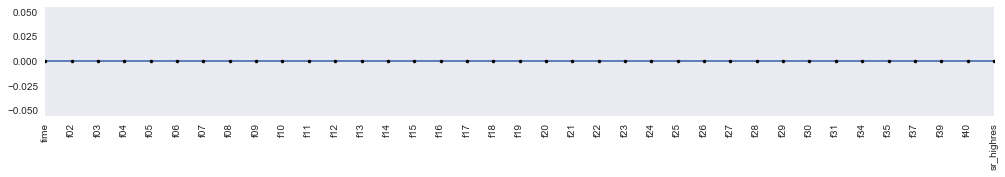

In [79]:
display(day_data.describe())
TSAPipe.visualizeNaN(day_data)
#print data1.isnull().sum()

### Moving average

In [80]:
time = day_data.time
day_data = day_data.drop('time', axis=1)

day_data = day_data.rolling(10080, center=True).mean() #10080 == 7days, 20160 == 14days
mdms_data = mdms_data.rolling(10080, center=True).mean()

day_data['time'] = time

In [81]:
display(day_data.describe())

,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
count,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000",...,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","280,833.0000"
mean,"22,547.4263","13,248.3965","8,299.7815","4,630.8916","1,591.4773",572.1335,715.2299,338.9623,172.3335,200.7757,...,0.3005,0.1369,0.1195,4.5672,169.3953,0.1814,39.6841,958.4120,-0.0059,"735,662.6777"
std,"8,326.2737","5,683.5645","3,944.0542","2,523.3831",878.2844,264.6388,276.9399,79.2559,37.4937,45.9688,...,0.1784,0.0812,0.0981,0.6717,26.5715,0.2806,6.2774,1.7781,0.0030,159.9837
min,"5,054.9487","2,783.3385","1,867.9584","1,188.7998",534.6291,238.4974,355.3430,187.4187,95.0047,100.5471,...,0.0680,0.0291,0.0065,3.2394,107.1005,0.0000,28.5814,954.9323,-0.0214,"735,397.8785"
25%,"16,578.3239","9,249.1112","5,500.0704","3,068.3132","1,069.9035",416.6218,548.3037,282.4777,143.7913,167.4512,...,0.1624,0.0771,0.0433,4.1415,153.9625,0.0139,34.3286,957.2412,-0.0068,"735,507.0965"
50%,"21,509.2247","11,946.4786","7,250.8394","3,836.6663","1,296.4622",495.5546,653.8046,329.5081,168.0849,197.8394,...,0.2518,0.1135,0.0898,4.5610,170.5726,0.0786,39.0569,958.2279,-0.0052,"735,672.1500"
75%,"29,412.8548","17,797.8889","11,030.5508","5,874.4586","1,766.3578",645.0306,809.2544,379.5182,196.7922,226.5586,...,0.3949,0.1826,0.1705,4.8485,187.9621,0.1832,44.8923,959.4702,-0.0040,"735,808.9896"
max,"43,477.5646","29,372.9869","21,063.6682","14,839.0475","5,237.1383","1,560.0402","1,978.6685",618.3511,285.0434,343.4379,...,0.9545,0.4273,0.4414,6.3397,235.1974,1.1895,52.4941,964.0041,-0.0008,"735,940.0604"


f02


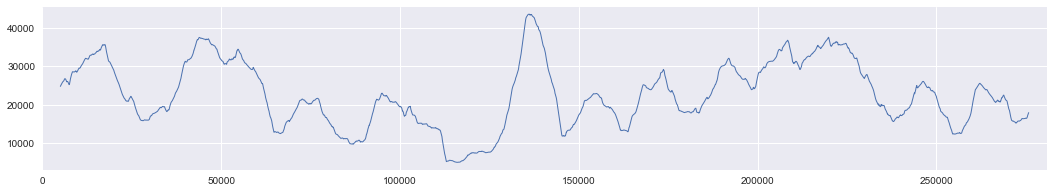

f03


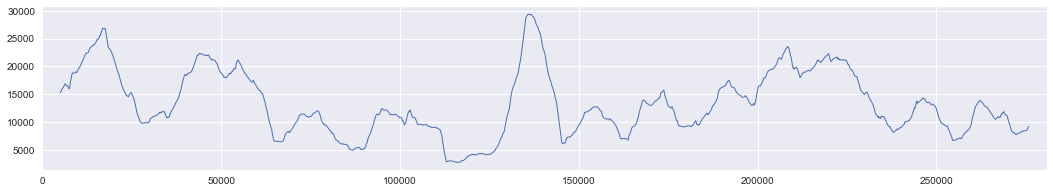

f04


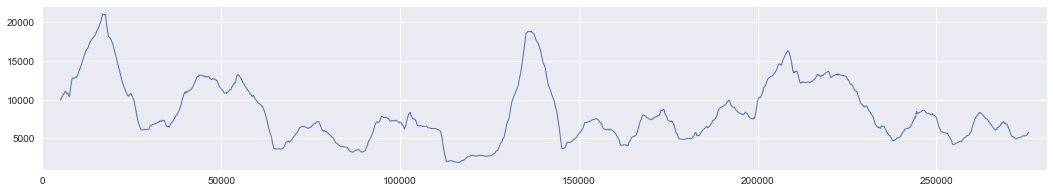

f05


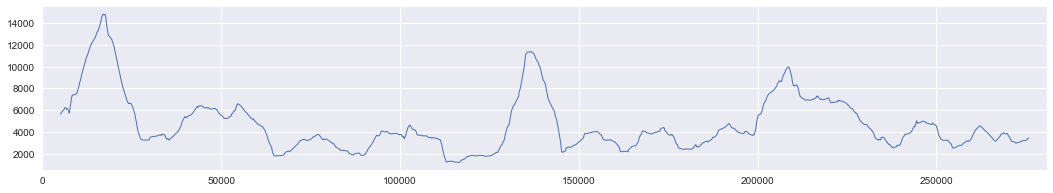

f06


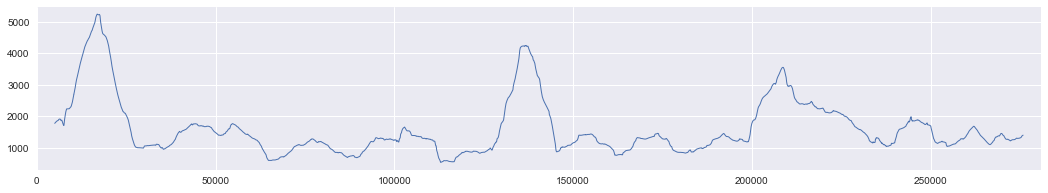

f07


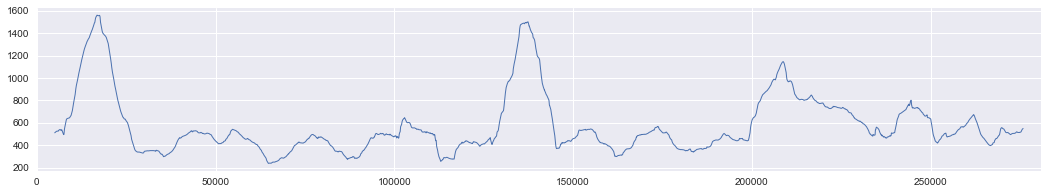

f08


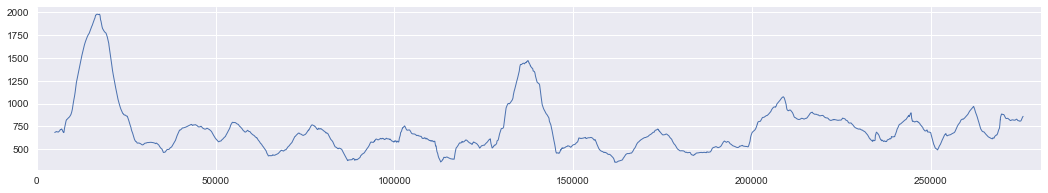

f09


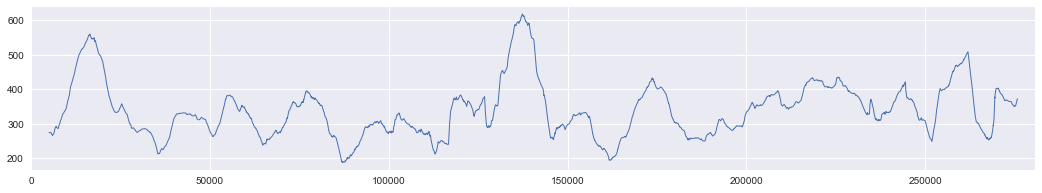

f10


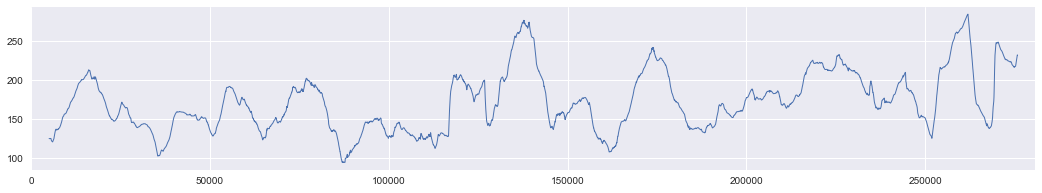

f11


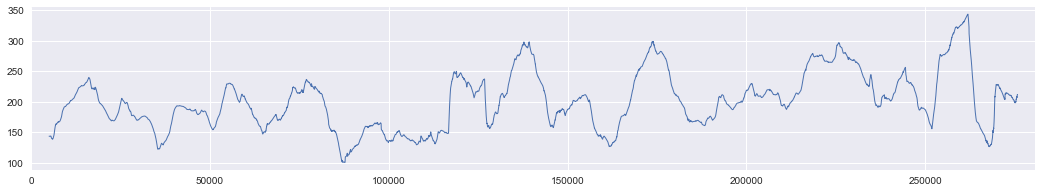

f12


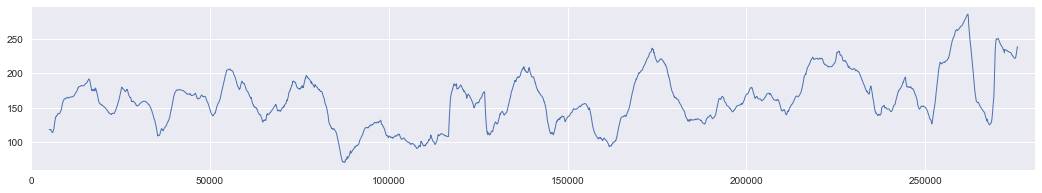

f13


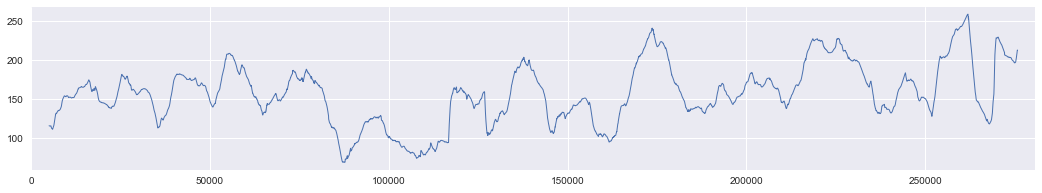

f14


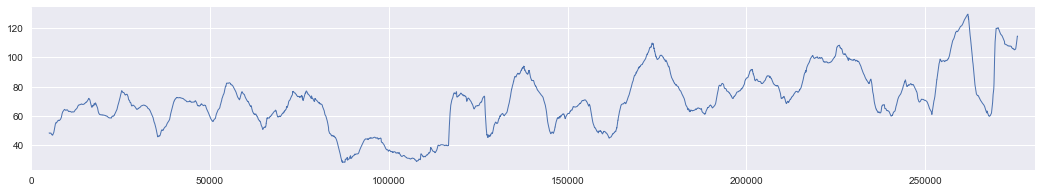

f15


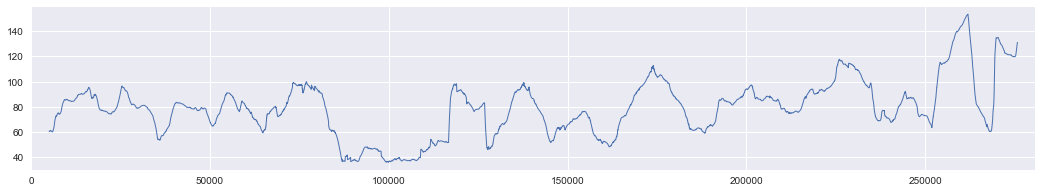

f16


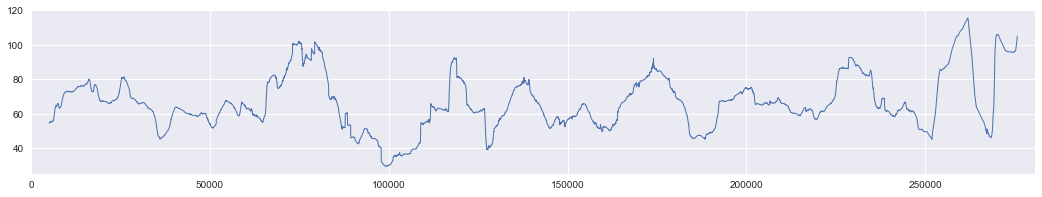

f17


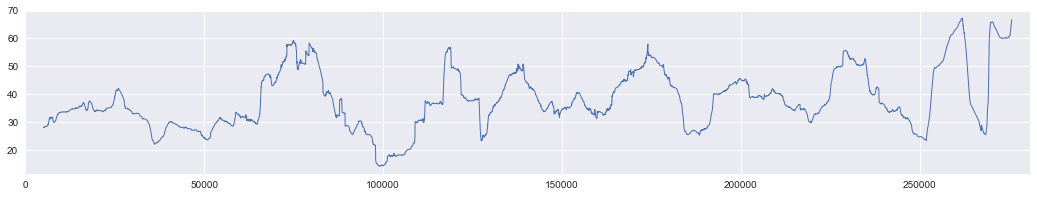

f18


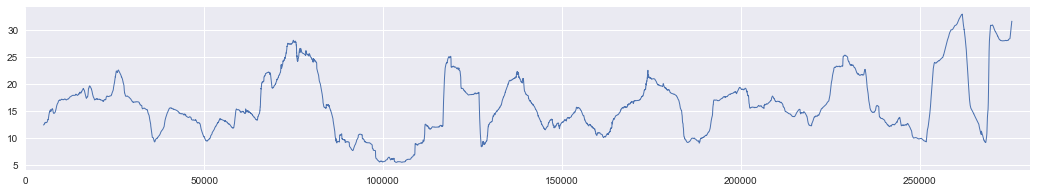

f19


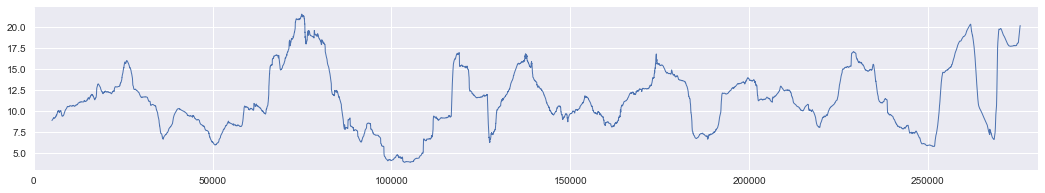

f20


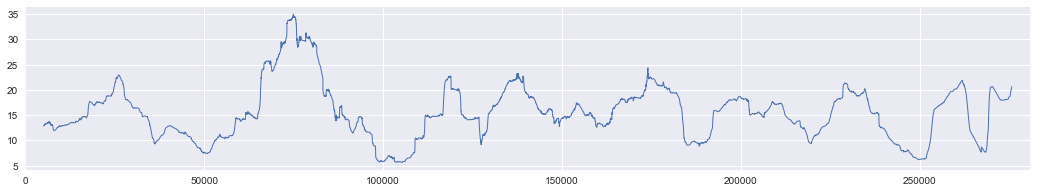

f21


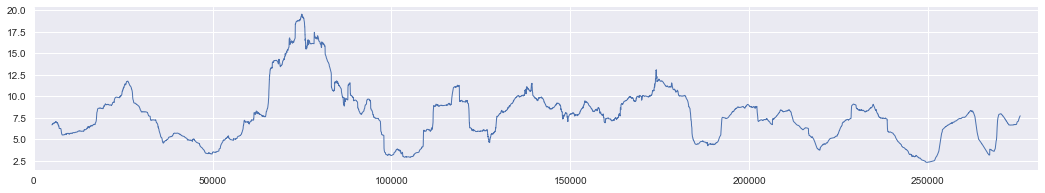

f22


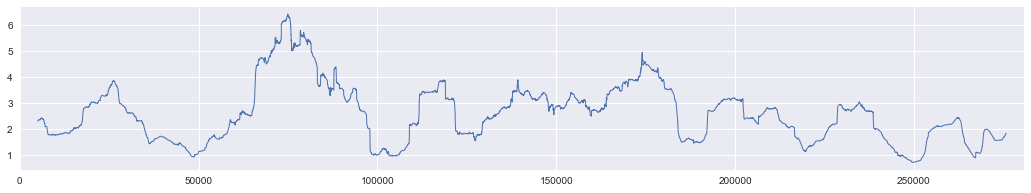

f23


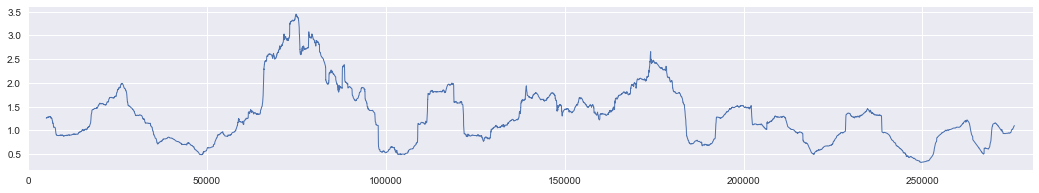

f24


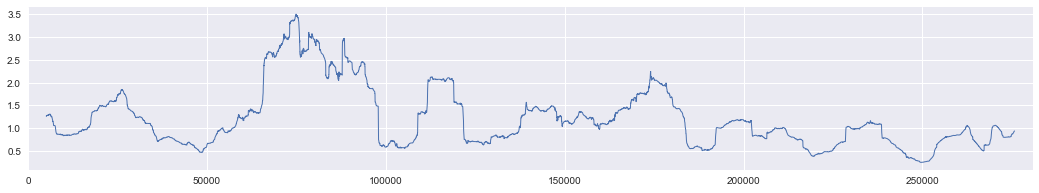

f25


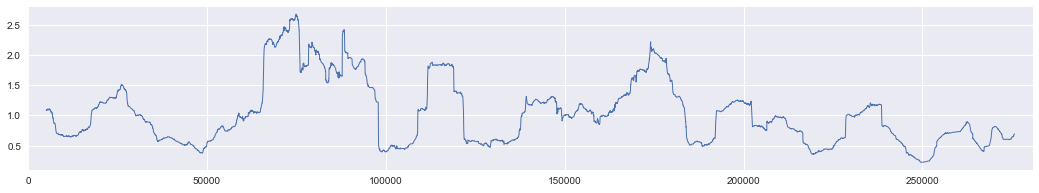

f26


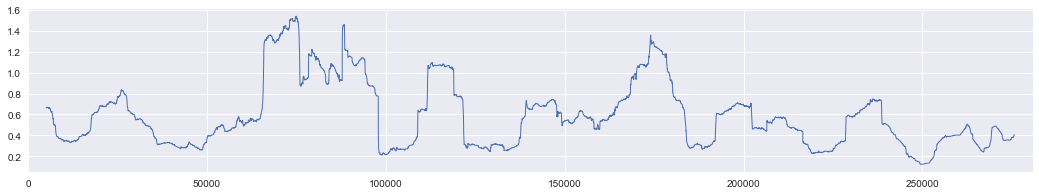

f27


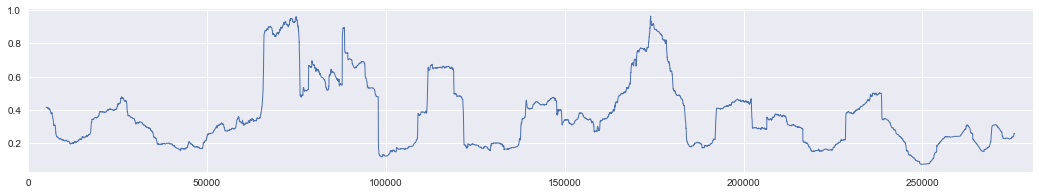

f28


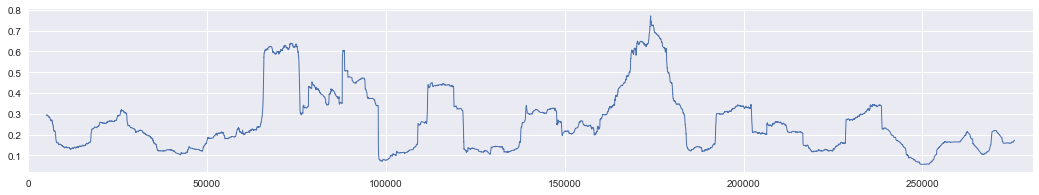

f29


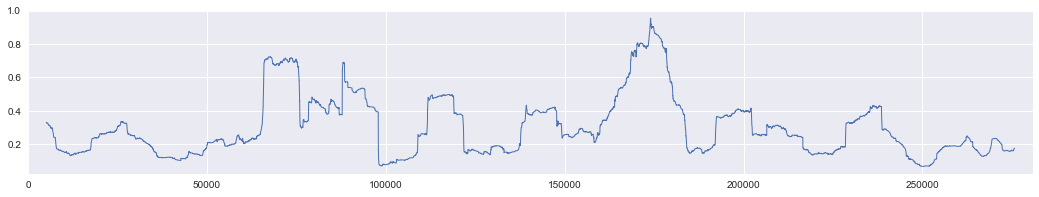

f30


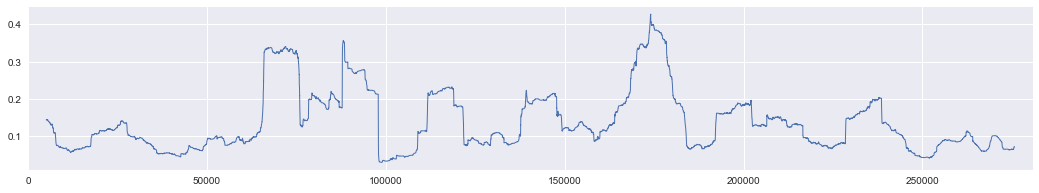

f31


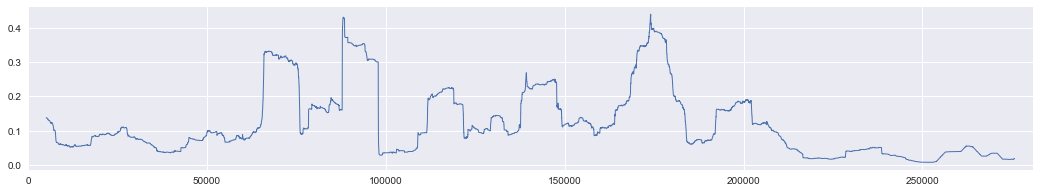

f34


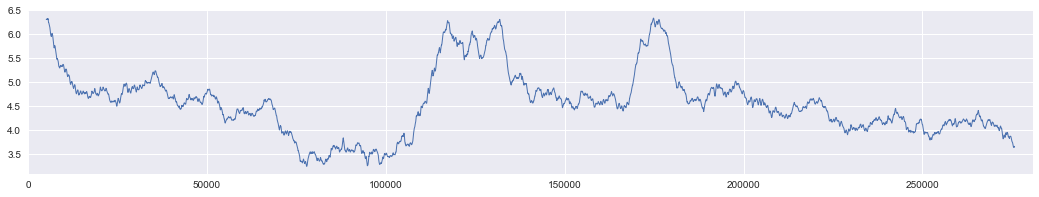

f35


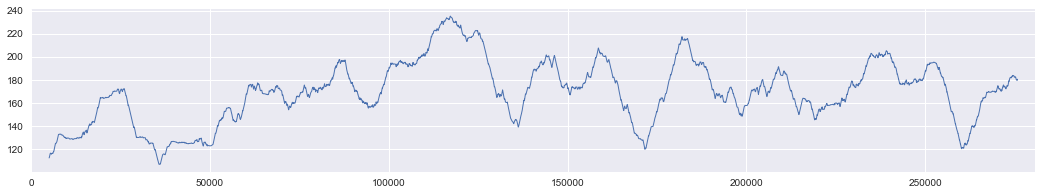

f37


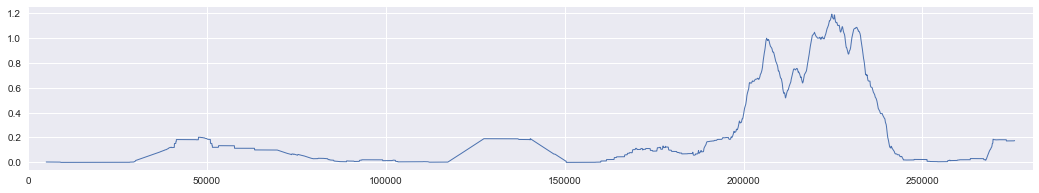

f39


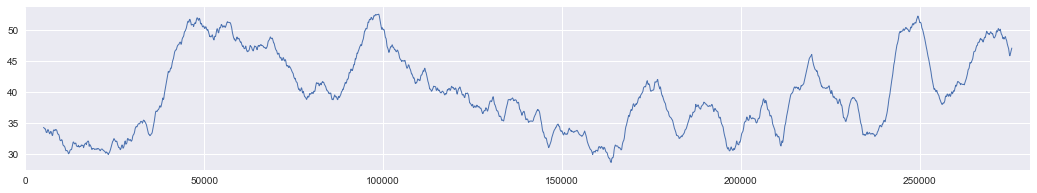

f40


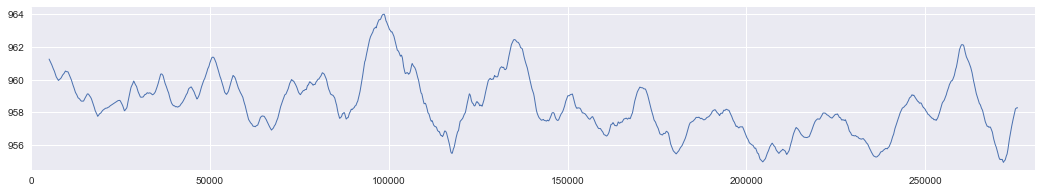

sr_highres


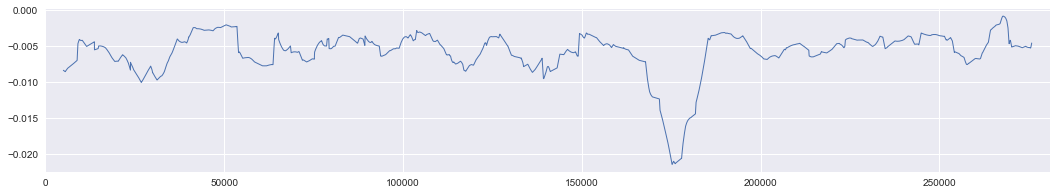

time


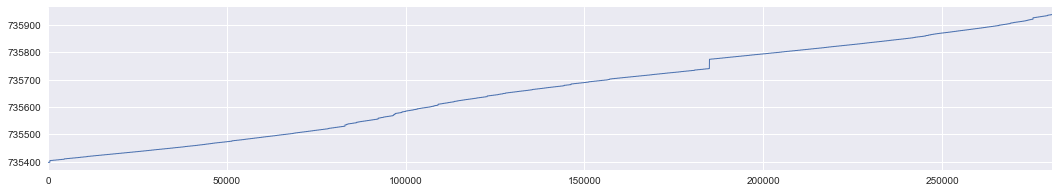

In [82]:
for e in day_data.columns.values:
    print e
    fig = plt.figure(figsize=(18,3))
    ax = fig.add_subplot(1,1,1)
    day_data[e].plot(lw=1)
    #plt.xlim(0, 59500)
    plt.show()

In [83]:
print('mean of sr should be 0:', day_data.sr_highres.mean())

('mean of sr should be 0:', -0.005855583399350655)


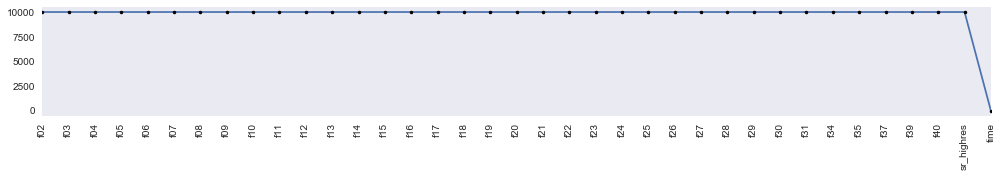

number of data points BEFORE dropping all rows with any NaN elements for selected features: 280833
number of data points AFTER dropping all rows with any NaN elements for selected features: 270754
10079 number of data points deleted



In [84]:
TSAPipe.visualizeNaN(day_data)
day_data = main.removeNaN(day_data, day_data.columns.values)

In [85]:
day_data = main.rebuild_index(day_data)

### Standardization

In [86]:
time = day_data.time
day_data = day_data.drop('time', axis=1)

mean = day_data.mean()
std = day_data.std()

day_data = (day_data - mean) / std
mdms_data = (mdms_data - mean) / std

day_data['time'] = time

In [87]:
display(day_data.describe())

,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
count,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000",...,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000"
mean,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,...,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,"735,662.4238"
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,154.8168
min,-2.1009,-1.8413,-1.6308,-1.3641,-1.2033,-1.2607,-1.2995,-1.9121,-2.0624,-2.1804,...,-1.3032,-1.3274,-1.1520,-1.9769,-2.3444,-0.6463,-1.7687,-1.9569,-5.1212,"735,411.1701"
25%,-0.7169,-0.7037,-0.7099,-0.6192,-0.5939,-0.5876,-0.6028,-0.7127,-0.7613,-0.7249,...,-0.7743,-0.7361,-0.7774,-0.6338,-0.5808,-0.5966,-0.8531,-0.6585,-0.3033,"735,511.1516"
50%,-0.1247,-0.2291,-0.2660,-0.3147,-0.3359,-0.2894,-0.2218,-0.1193,-0.1133,-0.0639,...,-0.2729,-0.2891,-0.3034,-0.0092,0.0443,-0.3663,-0.0999,-0.1036,0.2241,"735,672.1503"
75%,0.8245,0.8005,0.6924,0.4928,0.1991,0.2755,0.3395,0.5117,0.6523,0.5609,...,0.5293,0.5624,0.5202,0.4188,0.6988,0.0065,0.8297,0.5951,0.5948,"735,805.7790"
max,2.5137,2.8371,3.2362,4.0454,4.1509,3.7330,4.5621,3.5251,3.0061,3.1035,...,3.6661,3.5745,3.2832,2.6390,2.4764,3.5925,2.0407,3.1449,1.6523,"735,927.1014"


### Visualize feature distributions

In [ ]:
time = day_data.time
day_data = day_data.drop('time', axis=1)

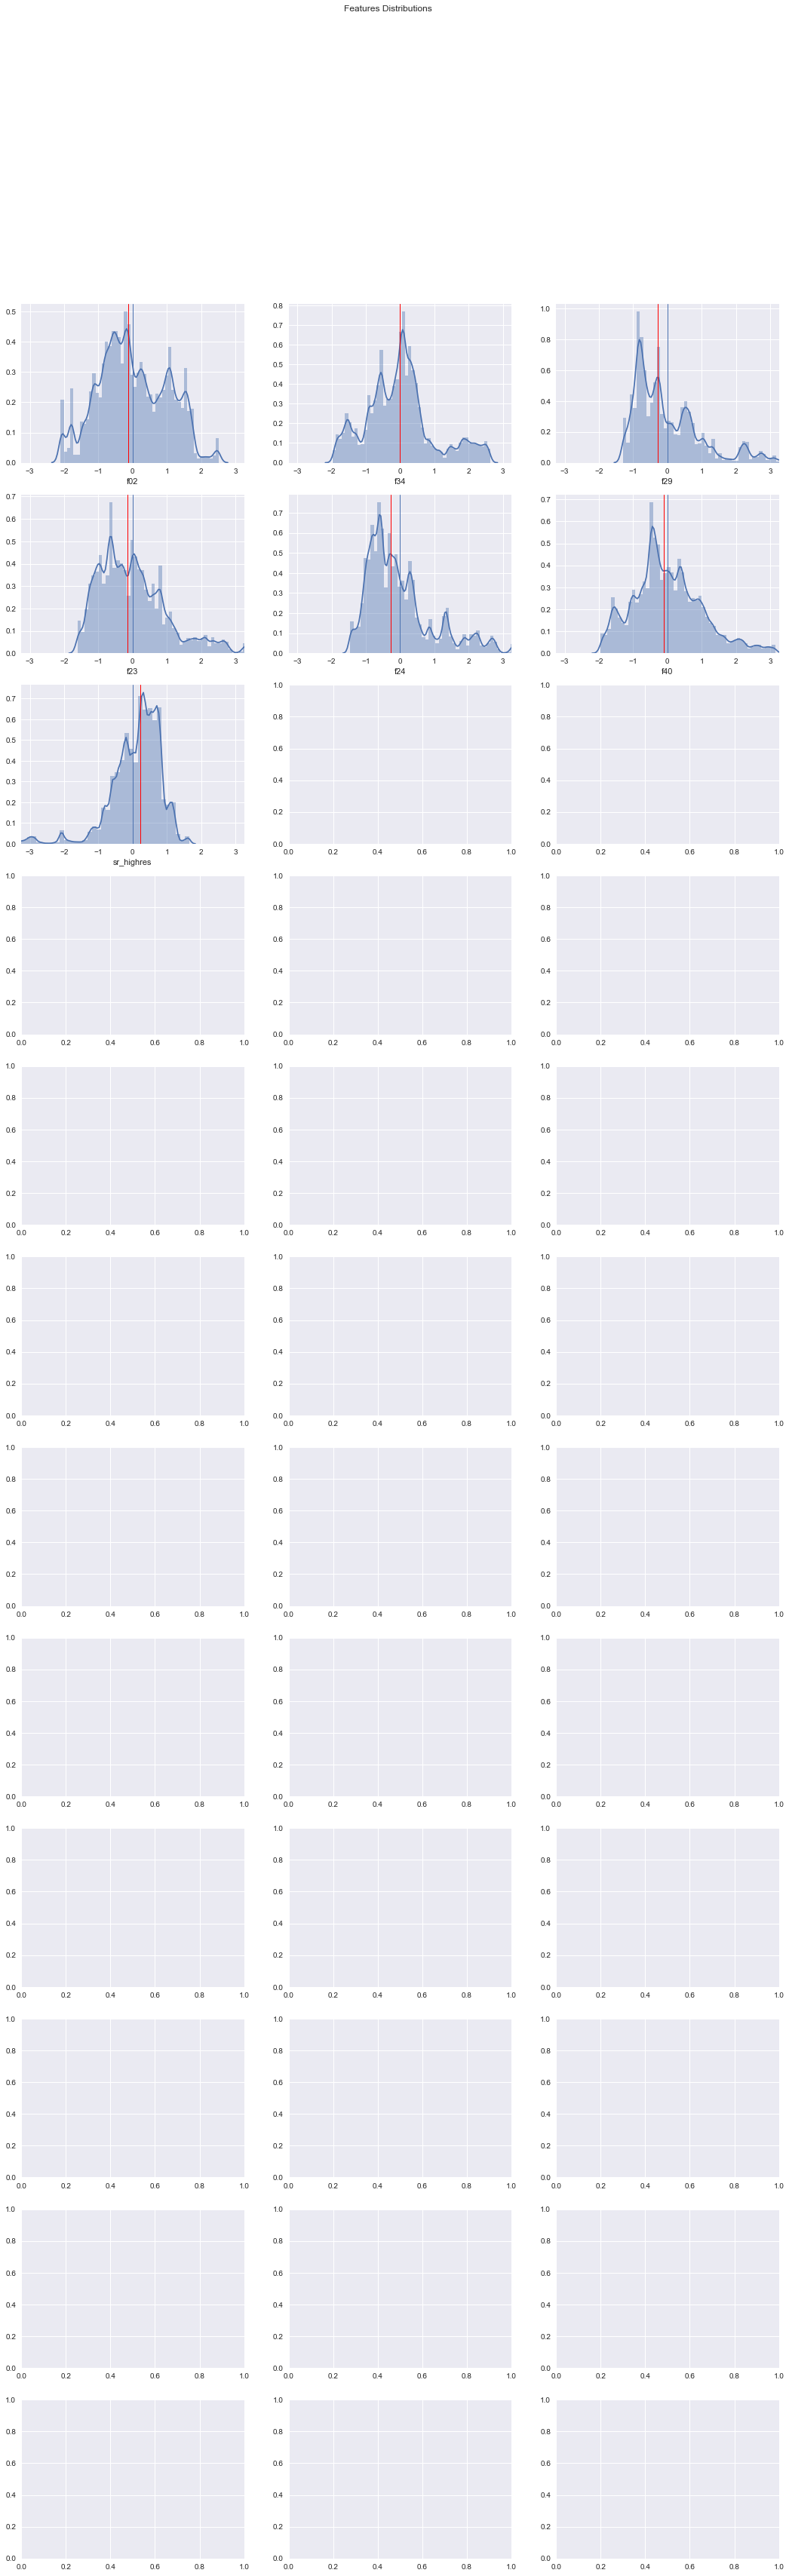

In [90]:
feats = ['f02', 'f34', 'f29', 'f23', 'f24', 'f40', 'sr_highres']

TSAPipe.vis_feat_distrib(day_data[feats], [12, 3], [-3.25, 3.25])

day_data['time'] = time

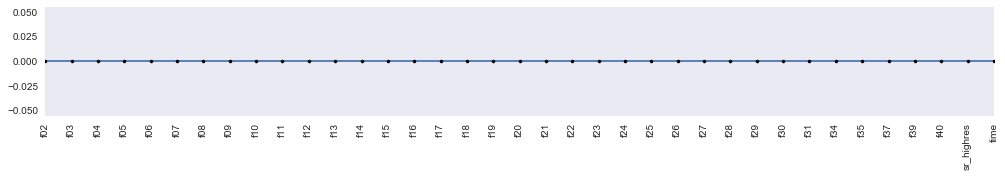

,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
Index,,,,,,,,,,,,,,,,,,,,,
0,0.2651,0.3575,0.4128,0.3957,0.2070,-0.2300,-0.1156,-0.8186,-1.2472,-1.2464,...,0.1601,0.0808,0.1865,2.5978,-2.1341,-0.6352,-0.8711,1.5978,-0.8223,"735,411.1701"
1,0.2653,0.3577,0.4130,0.3959,0.2072,-0.2300,-0.1156,-0.8187,-1.2472,-1.2464,...,0.1601,0.0808,0.1865,2.5979,-2.1339,-0.6352,-0.8712,1.5975,-0.8223,"735,411.1708"
2,0.2655,0.3579,0.4132,0.3960,0.2073,-0.2299,-0.1156,-0.8188,-1.2472,-1.2464,...,0.1601,0.0808,0.1865,2.5978,-2.1338,-0.6352,-0.8713,1.5973,-0.8224,"735,411.1715"
3,0.2657,0.3581,0.4134,0.3962,0.2074,-0.2299,-0.1156,-0.8188,-1.2474,-1.2464,...,0.1601,0.0808,0.1865,2.5978,-2.1337,-0.6352,-0.8713,1.5970,-0.8225,"735,411.1722"
4,0.2659,0.3583,0.4136,0.3964,0.2075,-0.2298,-0.1155,-0.8188,-1.2476,-1.2466,...,0.1596,0.0783,0.1865,2.5978,-2.1335,-0.6352,-0.8714,1.5968,-0.8226,"735,411.1729"


,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
count,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000",...,"270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000","270,754.0000"
mean,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,...,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,"735,662.4238"
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,154.8168
min,-2.1009,-1.8413,-1.6308,-1.3641,-1.2033,-1.2607,-1.2995,-1.9121,-2.0624,-2.1804,...,-1.3032,-1.3274,-1.1520,-1.9769,-2.3444,-0.6463,-1.7687,-1.9569,-5.1212,"735,411.1701"
25%,-0.7169,-0.7037,-0.7099,-0.6192,-0.5939,-0.5876,-0.6028,-0.7127,-0.7613,-0.7249,...,-0.7743,-0.7361,-0.7774,-0.6338,-0.5808,-0.5966,-0.8531,-0.6585,-0.3033,"735,511.1516"
50%,-0.1247,-0.2291,-0.2660,-0.3147,-0.3359,-0.2894,-0.2218,-0.1193,-0.1133,-0.0639,...,-0.2729,-0.2891,-0.3034,-0.0092,0.0443,-0.3663,-0.0999,-0.1036,0.2241,"735,672.1503"
75%,0.8245,0.8005,0.6924,0.4928,0.1991,0.2755,0.3395,0.5117,0.6523,0.5609,...,0.5293,0.5624,0.5202,0.4188,0.6988,0.0065,0.8297,0.5951,0.5948,"735,805.7790"
max,2.5137,2.8371,3.2362,4.0454,4.1509,3.7330,4.5621,3.5251,3.0061,3.1035,...,3.6661,3.5745,3.2832,2.6390,2.4764,3.5925,2.0407,3.1449,1.6523,"735,927.1014"


In [33]:
TSAPipe.visualizeNaN(day_data)

display(day_data.head())
display(day_data.describe())

### Save to data

In [34]:
data = day_data

### Load from data

In [35]:
day_data = data

### Splitting train/validation- and test data sets 

In [36]:

split_point = 210000 

#data2 = data1.iloc[520575:] # validation data set
day_data2 = day_data.iloc[split_point :] # validation data set
day_data2 = main.rebuild_index(day_data2)

#data1 = data1.iloc[:520575] # test data set
day_data = day_data.iloc[:split_point] # test data set
day_data = main.rebuild_index(day_data)

display(day_data.describe())
display(day_data2.describe())

,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
count,"210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000",...,"210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000"
mean,-0.0248,0.0155,0.0303,0.0353,0.0123,-0.0308,-0.0368,-0.1256,-0.2283,-0.2261,...,0.1556,0.1432,0.2703,0.1756,-0.0197,-0.2135,-0.1313,0.1240,-0.1223,"735,604.2573"
std,1.0351,1.0489,1.0644,1.0919,1.1095,1.1080,1.1141,1.0343,0.9015,0.8604,...,1.0513,1.0614,0.9789,1.0614,1.0615,0.6478,0.9984,0.9900,1.0811,124.7006
min,-2.1009,-1.8413,-1.6308,-1.3641,-1.2033,-1.2607,-1.2995,-1.9121,-2.0624,-2.1804,...,-1.2881,-1.3274,-0.9392,-1.9769,-2.3444,-0.6463,-1.7687,-1.9405,-5.1212,"735,411.1701"
25%,-0.7835,-0.7027,-0.7247,-0.6916,-0.6811,-0.7106,-0.6878,-0.8053,-0.8798,-0.8410,...,-0.7110,-0.6869,-0.4561,-0.2831,-0.7250,-0.6187,-0.9809,-0.5160,-0.4288,"735,486.0436"
50%,-0.1338,-0.2146,-0.2556,-0.3169,-0.3605,-0.3911,-0.3644,-0.3172,-0.3645,-0.2685,...,-0.1649,-0.1500,-0.1030,0.1435,0.0269,-0.3872,-0.2923,0.0429,0.1067,"735,612.1163"
75%,0.8524,0.8473,0.7432,0.5655,0.1644,-0.0493,0.1240,0.2843,0.3205,0.2948,...,0.6652,0.7312,0.6932,0.5739,0.7535,-0.1044,0.5516,0.7205,0.5477,"735,710.0530"
max,2.5137,2.8371,3.2362,4.0454,4.1509,3.7330,4.5621,3.5251,2.7933,2.1263,...,3.6661,3.5745,3.2832,2.6390,2.4764,2.9031,2.0407,3.1449,1.2571,"735,814.9368"


,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,...,f29,f30,f31,f34,f35,f37,f39,f40,sr_highres,time
count,"60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000",...,"60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000"
mean,0.0856,-0.0535,-0.1047,-0.1220,-0.0424,0.1065,0.1273,0.4342,0.7890,0.7817,...,-0.5379,-0.4950,-0.9344,-0.6070,0.0680,0.7379,0.4537,-0.4287,0.4227,"735,863.4801"
std,0.8624,0.8063,0.7257,0.5621,0.4462,0.4455,0.3811,0.7183,0.9192,1.0535,...,0.5133,0.4966,0.1358,0.2952,0.7455,1.5179,0.8637,0.9122,0.4314,30.7767
min,-1.2200,-1.1507,-1.0459,-0.8433,-0.6284,-0.6612,-0.8063,-1.1389,-1.2387,-1.6202,...,-1.3032,-1.1852,-1.1520,-1.3843,-1.8345,-0.6298,-1.1011,-1.9569,-0.5582,"735,814.9375"
25%,-0.6414,-0.7081,-0.6787,-0.5650,-0.4198,-0.2794,-0.2030,-0.0857,0.0524,0.0851,...,-0.8734,-0.8480,-1.0395,-0.8058,-0.3954,-0.5707,-0.1401,-1.0899,0.2132,"735,836.2002"
50%,-0.0874,-0.2930,-0.3429,-0.3096,-0.1720,0.0057,0.2261,0.4962,0.9933,0.7274,...,-0.6561,-0.6304,-0.9574,-0.6237,0.1717,-0.0330,0.2613,-0.4594,0.4253,"735,860.1885"
75%,0.5643,0.3332,0.1987,0.1128,0.2944,0.5564,0.4220,0.8978,1.3440,1.5884,...,-0.3297,-0.2750,-0.8255,-0.5047,0.5180,2.3766,1.3362,0.0243,0.6590,"735,888.9575"
max,1.7926,1.5894,1.3655,1.0593,0.9988,1.0430,0.9127,2.1425,3.0061,3.1035,...,0.7353,0.8198,-0.6617,0.1625,1.3525,3.5925,1.9906,2.0937,1.6523,"735,927.1014"


### Visualize time intervals of both data sets

In [37]:
print('Start/Stop dates for train/validation data set')
for e in day_data.time.iloc[[0, -1]]:
    print datetime.fromordinal(int(e))+ timedelta(days=e%1) - timedelta(days = 366)
print('number of data points: {}'.format(len(day_data)))

print('Start/Stop dates for test data set')
for e in day_data2.time.iloc[[0, -1]]:
    print datetime.fromordinal(int(e))+ timedelta(days=e%1) - timedelta(days = 366)
print('number of data points: {}'.format(len(day_data2)))
    
t_data1 = day_data

t_data2 = day_data2

day_data = day_data.drop('time', axis=1)
day_data2 = day_data2.drop('time', axis=1)

Start/Stop dates for train/validation data set
2013-06-26 04:05:00.000019
2014-08-03 22:29:00.000034
number of data points: 210000
Start/Stop dates for test data set
2014-08-03 22:30:00
2014-11-24 02:26:00.000011
number of data points: 60754


### Plotting soiling rate for train/valid. and test dat set

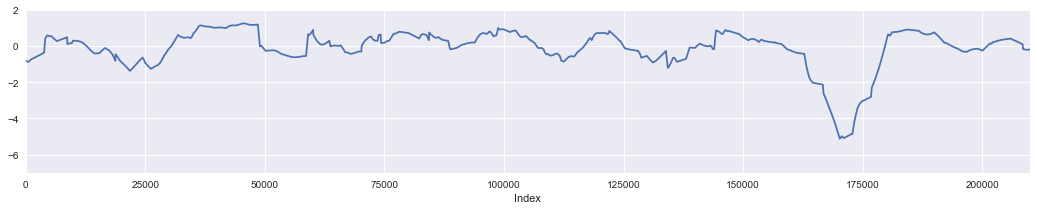

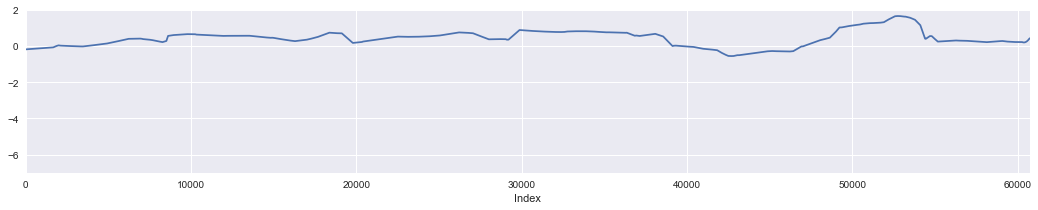

In [38]:
fig = plt.figure(figsize=(18,3))
day_data['sr_highres'].plot()
plt.ylim(-7, 2)
fig = plt.figure(figsize=(18,3))
day_data2['sr_highres'].plot()
plt.ylim(-7, 2)
plt.show()

### Splitting label and features

label has to be dropped from data, as the data is later used as features

In [39]:
#create labels and remove from data (features)

labels = day_data['sr_highres']
labels = pd.DataFrame(labels)
day_data = day_data.drop('sr_highres', axis=1)

labels2 = day_data2['sr_highres']
labels2 = pd.DataFrame(labels2)
day_data2 = day_data2.drop('sr_highres', axis=1)

In [40]:
print day_data.columns.values
print day_data2.columns.values

['f02' 'f03' 'f04' 'f05' 'f06' 'f07' 'f08' 'f09' 'f10' 'f11' 'f12' 'f13'
 'f14' 'f15' 'f16' 'f17' 'f18' 'f19' 'f20' 'f21' 'f22' 'f23' 'f24' 'f25'
 'f26' 'f27' 'f28' 'f29' 'f30' 'f31' 'f34' 'f35' 'f37' 'f39' 'f40']
['f02' 'f03' 'f04' 'f05' 'f06' 'f07' 'f08' 'f09' 'f10' 'f11' 'f12' 'f13'
 'f14' 'f15' 'f16' 'f17' 'f18' 'f19' 'f20' 'f21' 'f22' 'f23' 'f24' 'f25'
 'f26' 'f27' 'f28' 'f29' 'f30' 'f31' 'f34' 'f35' 'f37' 'f39' 'f40']


### Supervised Learner Pipeline

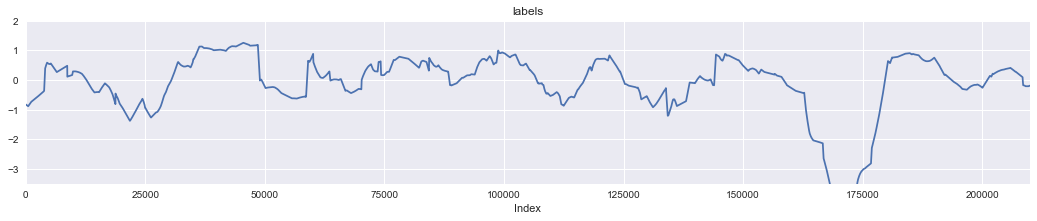

Variance of the train/valid. set: 1.16883280917


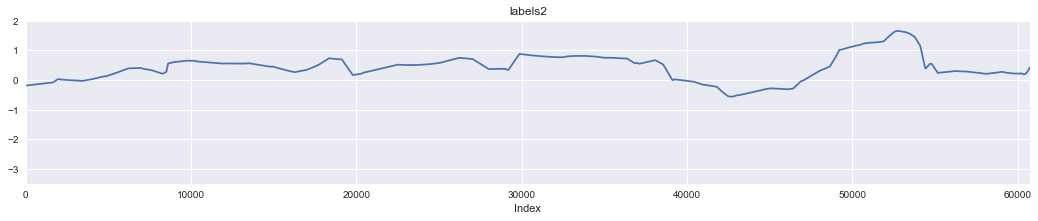

Variance of the test set: 0.18608734121


In [41]:
#display(data1.head())

plt.figure(figsize=(18,3))
labels['sr_highres'].plot()
plt.title('labels')
plt.ylim(-3.5, 2)
plt.show()

print('Variance of the train/valid. set: {}'.format(labels['sr_highres'].var()))

#plt.figure(figsize=(18,5))
#for e in data1:
#    data1[e].plot()
#plt.title('features')
#plt.legend(loc='best')
#plt.show()

plt.figure(figsize=(18,3))
labels2['sr_highres'].plot()
plt.title('labels2')
plt.ylim(-3.5, 2)
plt.show()

print('Variance of the test set: {}'.format(labels2['sr_highres'].var()))

#plt.figure(figsize=(18,5))
#for e in data1:
#    data2[e].plot()
#plt.title('features2')
#plt.legend(loc='best')
#plt.show()

In [42]:
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import main

reglist = [XGBRegressor(learning_rate=0.002, max_depth=3, n_estimators=1200)]

n_splits = 10
earlyStpRnds = 320

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.002, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 1 of 10


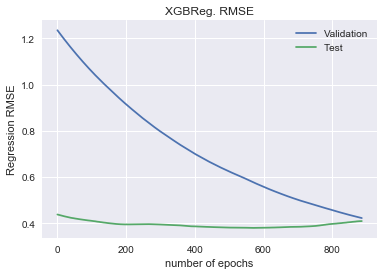

time to fit: 102.139000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 2 of 10


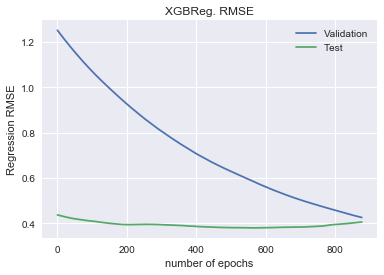

time to fit: 95.868000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 3 of 10


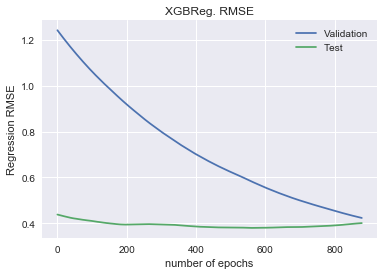

time to fit: 95.308000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 4 of 10


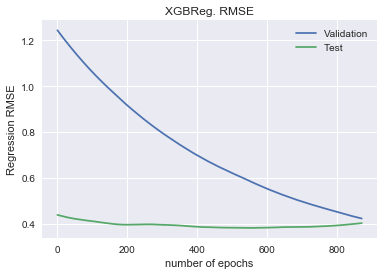

time to fit: 94.260000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 5 of 10


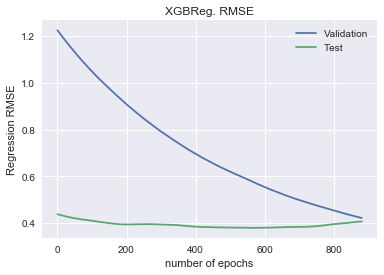

time to fit: 100.956000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 6 of 10


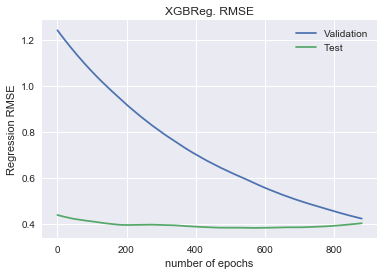

time to fit: 99.488000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 7 of 10


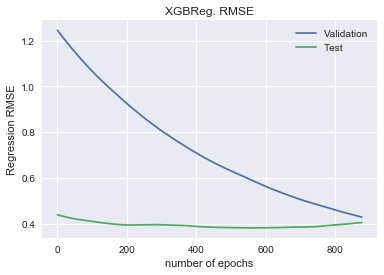

time to fit: 102.513000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 8 of 10


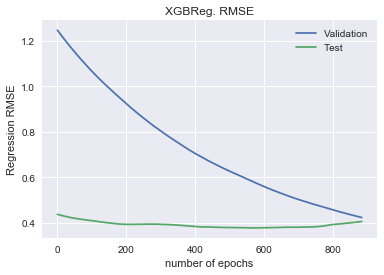

time to fit: 122.055000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 9 of 10


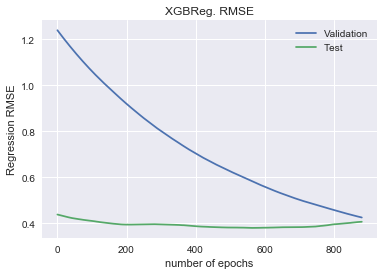

time to fit: 96.598000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 10 of 10


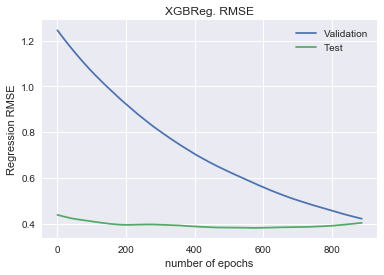

time to fit: 103.560000

Regressor R2 score on the validation set: 0.8490
---------------------------------------------------------------------
('size of the training set (features, labels)', (157500, 35), (157500L,))
('size of the validation set (features, labels)', (52500, 35), (52500, 1))
('size of the test set (features, labels)', (60754, 35), (60754, 1))
---------------------------------------------------------------------
Variance of the train/valid. set: 1.16883280917
Variance of the test set: 0.18608734121



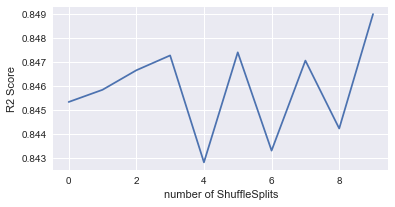

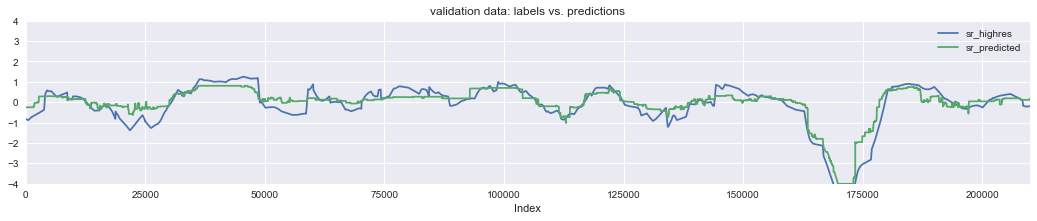

('validation set r2 score:', 0.84847156715886318)
validation set mean squared error: 17.71%
sr mean: -0.122281275742 | predicted mean: -0.0175570063293 | pred. deviation from sr: -85.64211387%


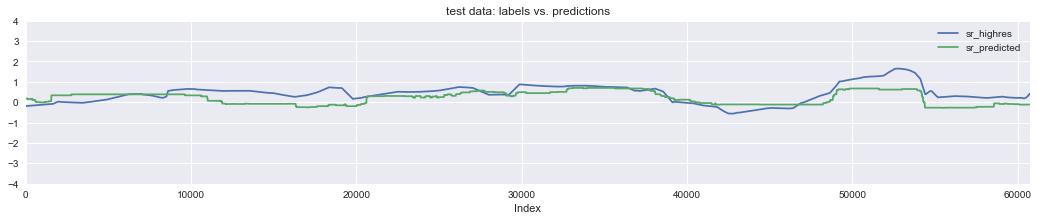

('test set r2 score:', 0.12633284601001993)
test set mean squared error: 16.26%
sr mean: 0.422672875954 | predicted mean: 0.211460843682 | pred. deviation from sr: -49.970566906%

No feature importance available for this learner




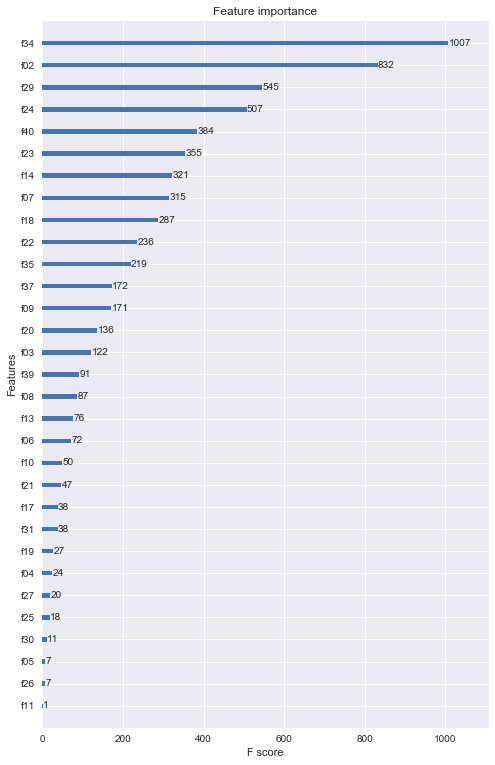

In [43]:
regressor, preds, preds2 = main.plot_shuffle_split_score(day_data, labels, 
                                                         day_data2, labels2, 
                                                         reglist, 
                                                         n_splits, earlyStpRnds)

## PCA

the cumulative explained variance of all commponents is 0.936507690462

The cumulated sums of the explained variances are: [ 0.4122451   0.72774382  0.79928849  0.85882114  0.90176326  0.93650769]

(210000, 6)


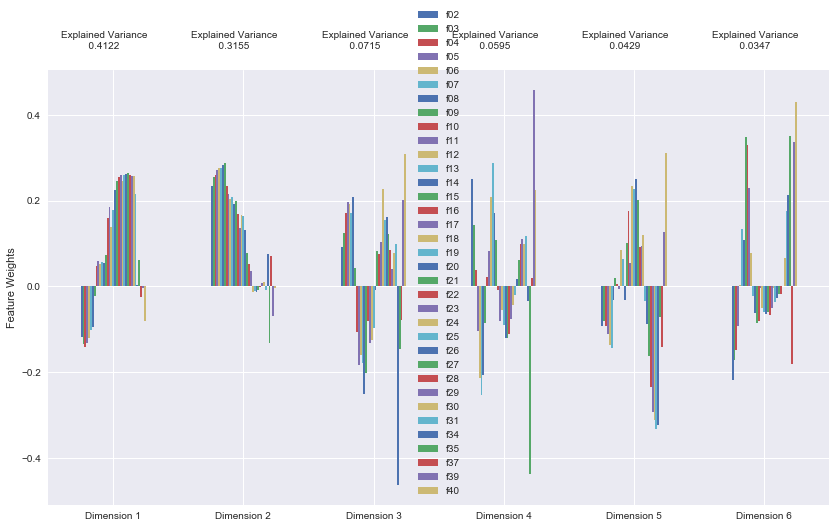

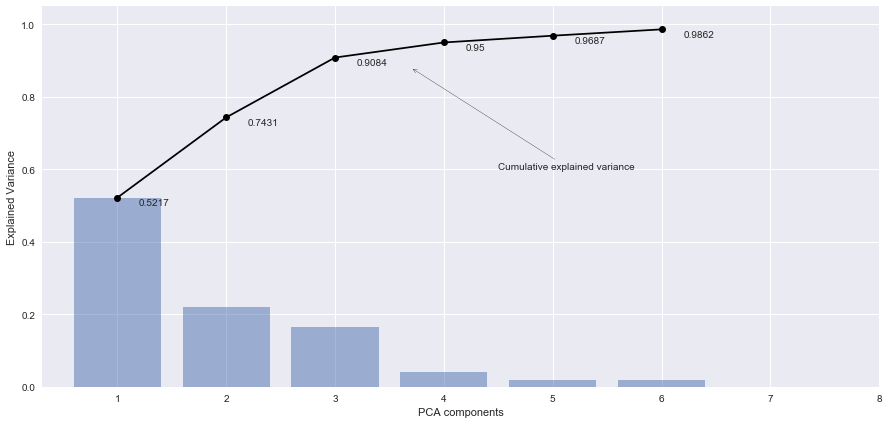

In [44]:
pca_data, pca_data2 = main.vis_pca(day_data, day_data2, 6)
cols = ['dim1', 'dim2', 'dim3', 
        'dim4', 'dim5', 'dim6'] 
#        'dim7', 'dim8', 'dim9',
#        'dim10', 'dim11', 'dim12']
pca_data.columns =  cols
pca_data2.columns = cols

In [45]:
mean = pca_data.mean()
std = pca_data.std()

pca_data = (pca_data - mean) / std
pca_data2 = (pca_data2 - mean) / std

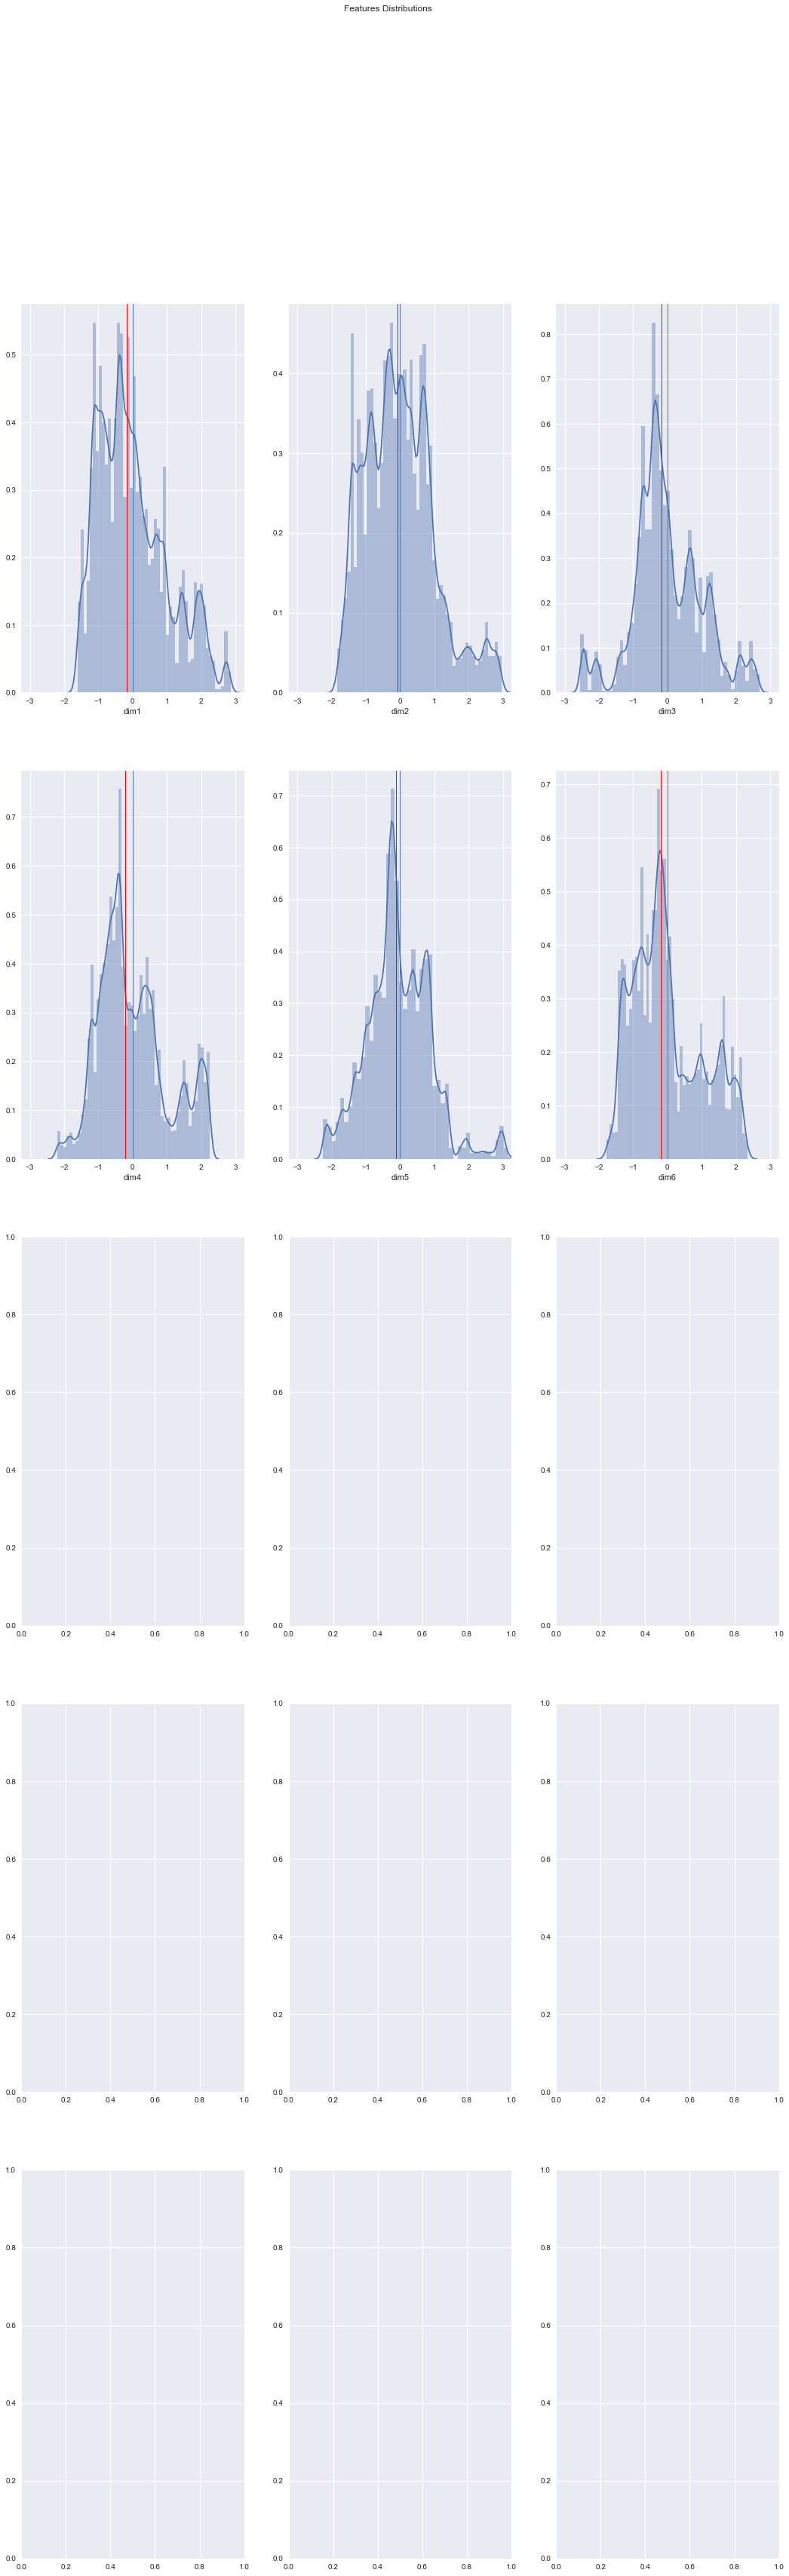

In [46]:
TSAPipe.vis_feat_distrib(pca_data, [5, 3], [-3.25, 3.25])

In [47]:
display(pca_data.describe())
display(pca_data2.describe())

display(labels.describe())
display(labels2.describe())

,dim1,dim2,dim3,dim4,dim5,dim6
count,"210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000","210,000.0000"
mean,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-1.6144,-1.8272,-2.5434,-2.2038,-2.2426,-1.7771
25%,-0.7978,-0.7783,-0.6026,-0.7097,-0.6126,-0.7674
50%,-0.1684,-0.0688,-0.1656,-0.2279,-0.1193,-0.1963
75%,0.6415,0.6322,0.6586,0.5561,0.6060,0.7218
max,2.8535,2.9574,2.6871,2.2504,3.8809,2.3403


,dim1,dim2,dim3,dim4,dim5,dim6
count,"60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000","60,754.0000"
mean,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000
std,0.9215,0.6863,1.2451,0.6848,0.5402,0.5813
min,-1.7275,-0.8219,-1.7954,-1.1268,-1.3888,-1.0009
25%,-0.7523,-0.5186,-0.8644,-0.5501,-0.2777,-0.4548
50%,-0.1026,-0.2726,-0.3190,0.0334,-0.0547,-0.1112
75%,0.7284,0.2037,0.6929,0.3320,0.1952,0.3864
max,2.0687,1.5854,2.8400,1.7691,1.4596,1.4525


,sr_highres
count,"210,000.0000"
mean,-0.1223
std,1.0811
min,-5.1212
25%,-0.4288
50%,0.1067
75%,0.5477
max,1.2571


,sr_highres
count,"60,754.0000"
mean,0.4227
std,0.4314
min,-0.5582
25%,0.2132
50%,0.4253
75%,0.6590
max,1.6523


-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.002, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 1 of 10


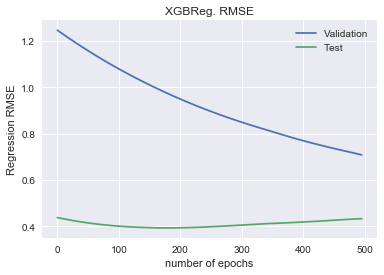

time to fit: 16.364000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 2 of 10


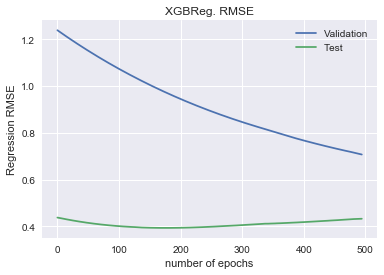

time to fit: 18.763000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 3 of 10


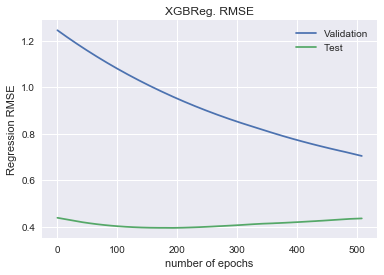

time to fit: 16.511000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 4 of 10


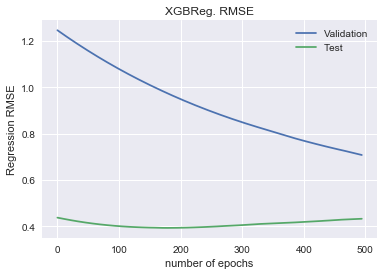

time to fit: 19.181000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 5 of 10


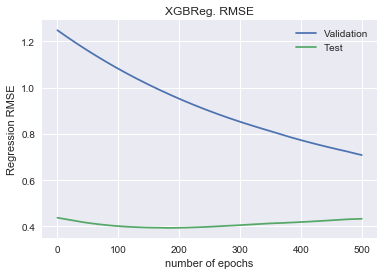

time to fit: 16.210000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 6 of 10


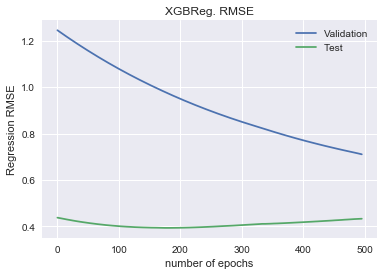

time to fit: 15.982000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 7 of 10


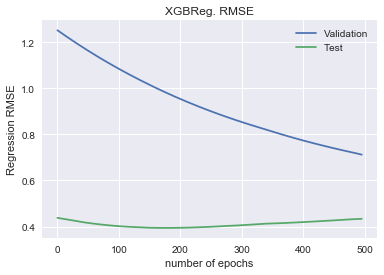

time to fit: 16.334000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 8 of 10


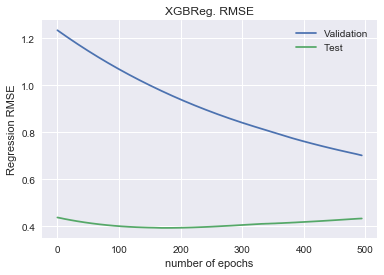

time to fit: 17.459000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 9 of 10


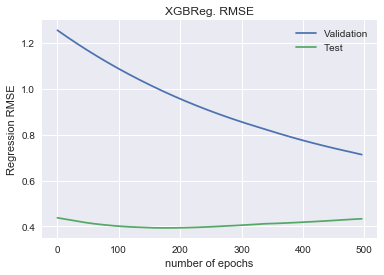

time to fit: 15.942000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 10 of 10


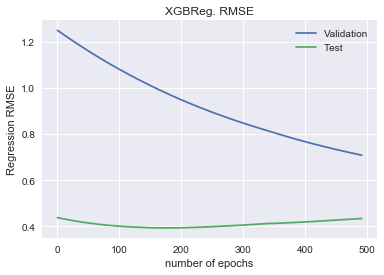

time to fit: 17.113000

Regressor R2 score on the validation set: 0.5754
---------------------------------------------------------------------
('size of the training set (features, labels)', (157500, 6), (157500L,))
('size of the validation set (features, labels)', (52500, 6), (52500, 1))
('size of the test set (features, labels)', (60754, 6), (60754, 1))
---------------------------------------------------------------------
Variance of the train/valid. set: 1.16883280917
Variance of the test set: 0.18608734121



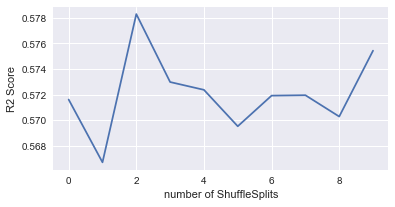

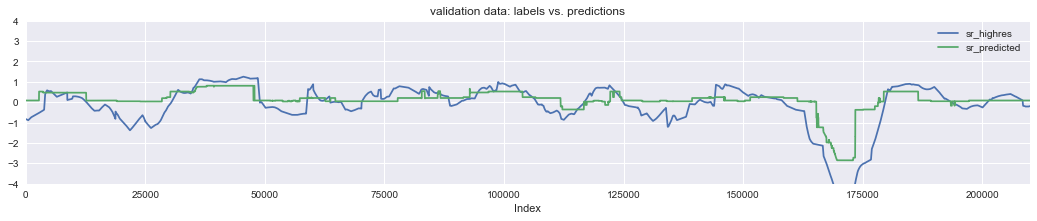

('validation set r2 score:', 0.56922009649867822)
validation set mean squared error: 50.35%
sr mean: -0.122281275742 | predicted mean: 0.108810335398 | pred. deviation from sr: -188.983644256%


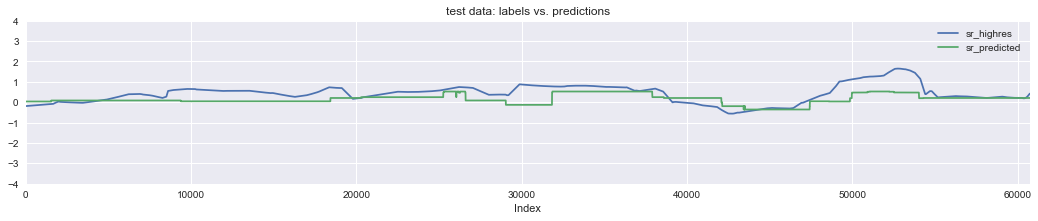

('test set r2 score:', -0.012964940907429279)
test set mean squared error: 18.85%
sr mean: 0.422672875954 | predicted mean: 0.154031068087 | pred. deviation from sr: -63.5578536383%

No feature importance available for this learner




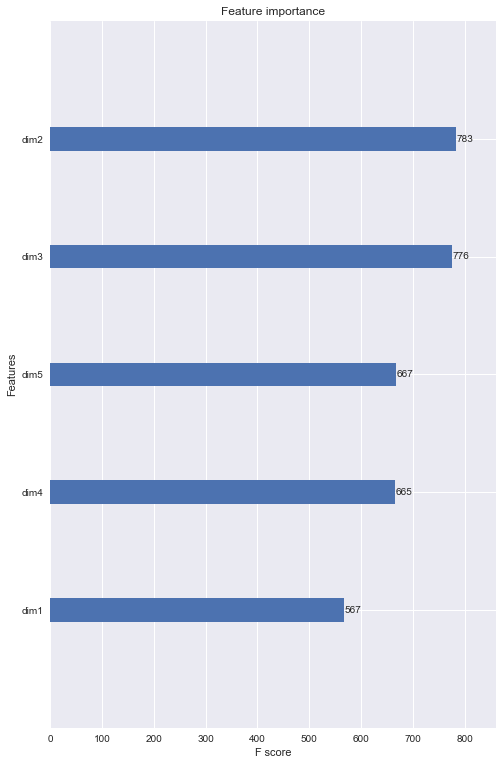

In [48]:
regressor, preds, preds2 = main.plot_shuffle_split_score(pca_data, labels, 
                                                         pca_data2, labels2, 
                                                         reglist, 
                                                         n_splits, earlyStpRnds)

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import main

#reglist = [LinearRegression(),
#           SGDRegressor(), 
#           Ridge(),
#           LinearSVR(), 
#           SVR(kernel='linear'), 
#           SVR(), 
reglist = [ExtraTreesRegressor(max_depth=6),
           AdaBoostRegressor(),
           XGBRegressor(),
           MLPRegressor()]

main.spotCheck(day_data, labels,
          day_data2, labels2, 
          reglist)

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=6,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 1 of 2
time to fit: 4.009000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 2 of 2
time to fit: 4.117000
---------------------------------------------------------------------
('size of the training set (features, labels)', (157500, 35), (15750

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.003, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 1 of 10


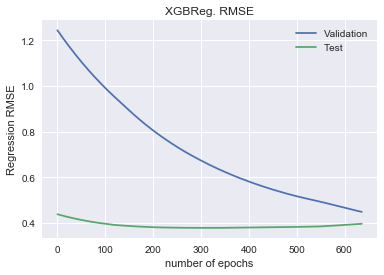

time to fit: 22.190000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 2 of 10


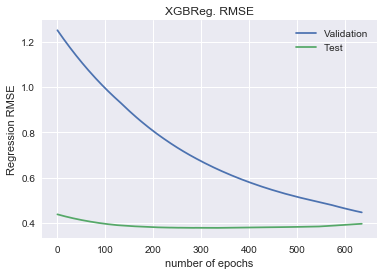

time to fit: 20.752000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 3 of 10


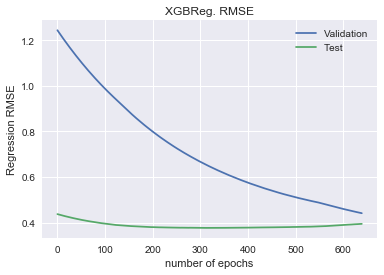

time to fit: 20.778000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 4 of 10


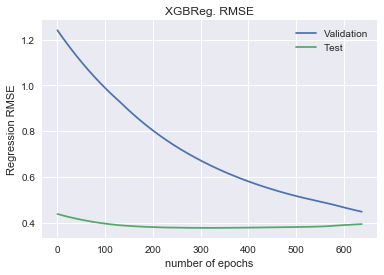

time to fit: 21.051000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 5 of 10


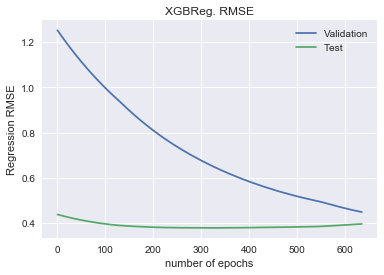

time to fit: 23.228000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 6 of 10


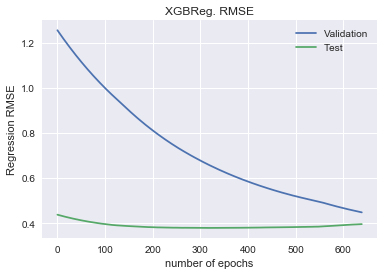

time to fit: 21.529000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 7 of 10


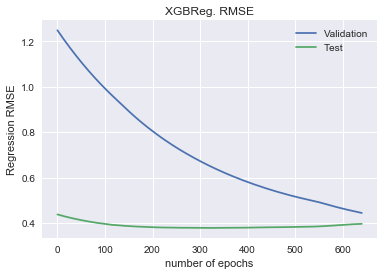

time to fit: 20.767000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 8 of 10


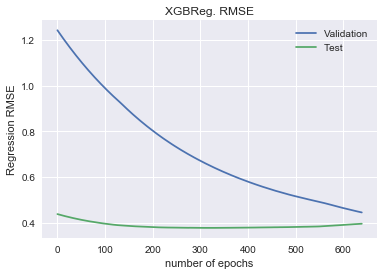

time to fit: 20.710000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 9 of 10


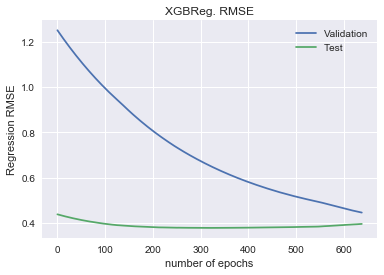

time to fit: 20.998000
---------------------------------------------------------------------------------------------------
ShuffledSplit iteration 10 of 10


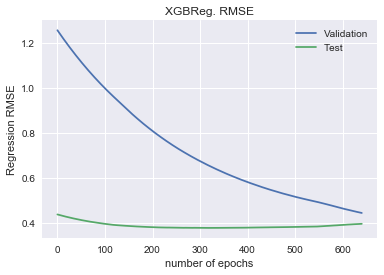

time to fit: 20.747000

Regressor R2 score on the validation set: 0.8348
---------------------------------------------------------------------
('size of the training set (features, labels)', (157500, 6), (157500L,))
('size of the validation set (features, labels)', (52500, 6), (52500, 1))
('size of the test set (features, labels)', (60754, 6), (60754, 1))
---------------------------------------------------------------------
Variance of the train/valid. set: 1.16883280917
Variance of the test set: 0.18608734121



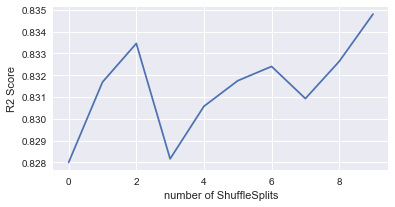

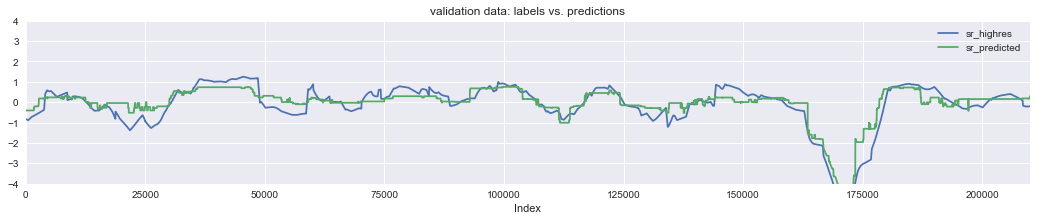

('validation set r2 score:', 0.83195009435545719)
validation set mean squared error: 19.64%
sr mean: -0.122281275742 | predicted mean: -0.0312911383808 | pred. deviation from sr: -74.4105234501%


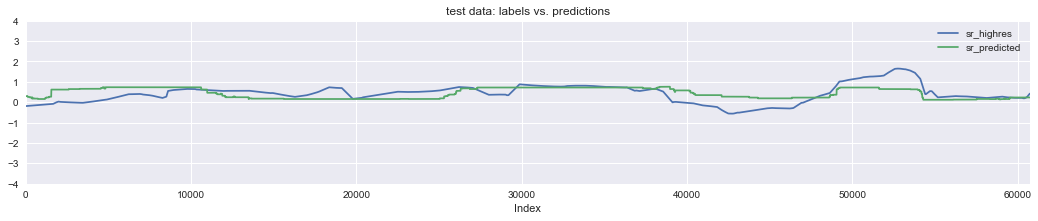

('test set r2 score:', 0.1571287895169925)
test set mean squared error: 15.68%
sr mean: 0.422672875954 | predicted mean: 0.44134619832 | pred. deviation from sr: 4.4179135753%

No feature importance available for this learner




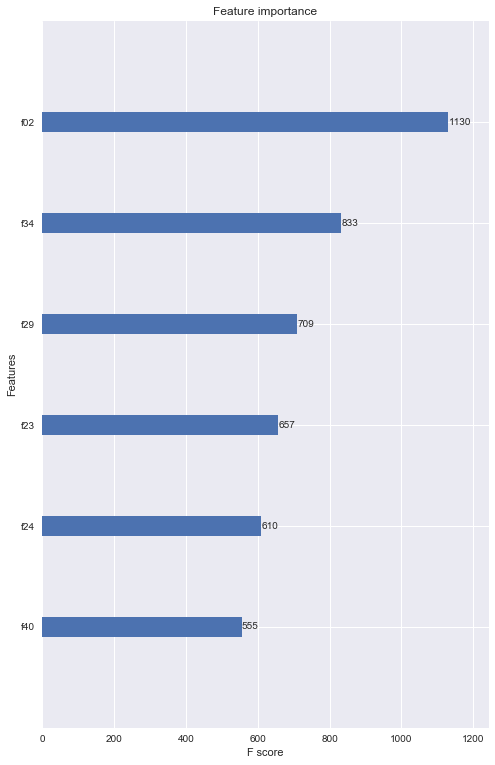

In [58]:
reglist = [XGBRegressor(learning_rate=0.003, max_depth=3, n_estimators=1200)]

reduced_feats = ['f34', 'f02', 'f29', 'f24', 'f40', 'f23']

regressor, preds, preds2 = main.plot_shuffle_split_score(day_data[reduced_feats], labels, 
                                                         day_data2[reduced_feats], labels2, 
                                                         reglist, 
                                                         n_splits, earlyStpRnds)

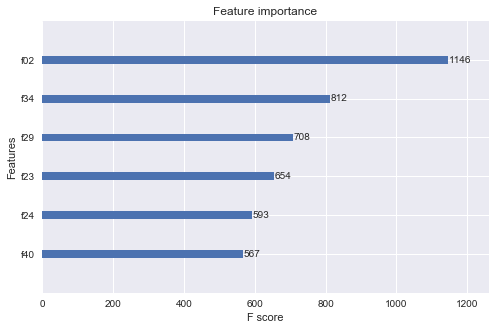

In [57]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_importance(regressor, ax=ax)
plt.show()